In [1]:
#Ref - https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
import pandas as pd
import numpy as np
import datetime
import talib as ta
import matplotlib.pyplot as plt
import seaborn as sns
import talib as ta

In [2]:
#Read data
data = pd.read_csv('data/analysis/D1_XAUUSD_Returns.csv', parse_dates=[0], index_col='Date')
#print(data.head())

In [3]:
#Date related features
data['Week'] = data.index.week
data['Day_Week'] = data.index.dayofweek
data['daily_return'] = data.Close.pct_change().mul(100)
data['day_week_sin'] = np.sin(data.Day_Week*(2.*np.pi/7))
data['day_week_cos'] = np.cos(data.Day_Week*(2.*np.pi/7))
data['week_sin'] = np.sin((data.Week-1)*(2.*np.pi/52))
data['week_cos'] = np.cos((data.Week-1)*(2.*np.pi/52))
data['yearday_sin'] = np.sin((data.Yearday)*(2.*np.pi/365.25))
data['yearday_cos'] = np.cos((data.Yearday)*(2.*np.pi/365.25))
#Simple Moving Average - 50 day
data['SMA_50'] = ta.SMA(data.Close, timeperiod = 50)
#Simple Moving Average - 200 day
data['SMA_200'] = ta.SMA(data.Close, timeperiod = 200)
# Exponential Moving Average - 9 day
data['EMA_9'] = ta.EMA(data.Close, timeperiod = 9)
# Exponential Moving Average - 21 day
data['EMA_21'] = ta.EMA(data.Close, timeperiod = 21)
# MACD
data['macd'], data['macdsignal'], data['macdhist'] = ta.MACD(data.Close, fastperiod=12, slowperiod=200, signalperiod=9)
# RSI
data['RSI'] = ta.RSI(data.Close, timeperiod=14)
#Define relative indicators
data['SMA_Delta'] = (data['SMA_50'] - data['SMA_200']) / data['Close']
#Define relative indicators
data['EMA_Delta'] = (data['EMA_9'] - data['EMA_21']) / data['Close']

In [4]:
print(data.tail())

               Open     High      Low    Close  Volume   Weekday  Yearday  \
Date                                                                        
2019-04-25  1274.63  1282.53  1273.31  1278.56   97134  Thursday      115   
2019-04-26  1278.56  1288.61  1273.72  1285.69  107326    Friday      116   
2019-04-28  1286.28  1286.62  1285.63  1285.80    1913    Sunday      118   
2019-04-29  1285.79  1286.57  1277.99  1280.33   80222    Monday      119   
2019-04-30  1280.32  1286.12  1279.84  1283.11  103615   Tuesday      120   

            Daily_return  Log_daily_Return  Week  ...     SMA_50     SMA_200  \
Date                                              ...                          
2019-04-25      0.308325          0.003079    17  ...  1295.9396  1260.27820   
2019-04-26      0.557659          0.005561    17  ...  1295.0698  1260.74670   
2019-04-28      0.008556          0.000086    17  ...  1294.3640  1261.19035   
2019-04-29     -0.425416         -0.004263    18  ...  1293.

In [5]:
#Choosing target variable
#data['Large_return'] = np.where(data['daily_return']>=0.5, 1, (np.where(data['daily_return']<=-0.5, -1, 0)))
data['Large_return'] = np.where(data['daily_return']>0.1, 1, 0)

In [6]:
#Drop rows with nan values
data.dropna(inplace=True)

In [7]:
#Pick features
features_list = ['Open', 'High', 'Low', 'Close', 'Volume','day_week_sin','day_week_cos','week_sin','week_cos','yearday_sin','yearday_cos',
                 'macdhist', 'RSI', 'SMA_Delta','EMA_Delta']
features = data[features_list]
features.head()

,Open,High,Low,Close,Volume,day_week_sin,day_week_cos,week_sin,week_cos,yearday_sin,yearday_cos,macdhist,RSI,SMA_Delta,EMA_Delta
Date,,,,,,,,,,,,,,,
2004-01-12,425.85,428.46,422.22,424.60,20736,0.000000,1.000000,0.239316,0.970942,0.204966,0.978769,2.239954,70.847411,0.071611,0.011534
2004-01-13,424.60,426.39,421.65,423.70,21473,0.781831,0.623490,0.239316,0.970942,0.221772,0.975099,1.835514,68.227339,0.072198,0.010996
2004-01-14,423.39,424.40,416.78,419.30,20415,0.974928,-0.222521,0.239316,0.970942,0.238513,0.971139,0.945729,57.107955,0.073547,0.009352
2004-01-15,418.98,421.10,406.91,408.45,22449,0.433884,-0.900969,0.239316,0.970942,0.255182,0.966893,-0.982156,39.857679,0.075568,0.005214
2004-01-16,408.55,410.40,404.43,406.30,19571,-0.433884,-0.900969,0.239316,0.970942,0.271777,0.962360,-2.539018,37.444023,0.076086,0.001362


In [8]:
#Pick target variable 
target_unshifted = data['Large_return']
#Add shift so we can predict target on time t=1 with features from time t
target = target_unshifted.shift(-1)
#Drop last value from features and target (Nan)
features = features[:-1]
target = target[:-1]
print(features.tail())
print(target.tail())

               Open     High      Low    Close  Volume  day_week_sin  \
Date                                                                   
2019-04-24  1271.37  1278.47  1268.70  1274.63   97655      0.974928   
2019-04-25  1274.63  1282.53  1273.31  1278.56   97134      0.433884   
2019-04-26  1278.56  1288.61  1273.72  1285.69  107326     -0.433884   
2019-04-28  1286.28  1286.62  1285.63  1285.80    1913     -0.781831   
2019-04-29  1285.79  1286.57  1277.99  1280.33   80222      0.000000   

            day_week_cos  week_sin  week_cos  yearday_sin  yearday_cos  \
Date                                                                     
2019-04-24     -0.222521  0.935016 -0.354605     0.924803    -0.380447   
2019-04-25     -0.900969  0.935016 -0.354605     0.918121    -0.396299   
2019-04-26     -0.900969  0.935016 -0.354605     0.911169    -0.412034   
2019-04-28      0.623490  0.935016 -0.354605     0.896456    -0.443132   
2019-04-29      1.000000  0.885456 -0.464723     0.

In [9]:
def split_train_test(data, train_ratio):
    indices = np.arange(len(data))
    train_set_size = int(len(data) * train_ratio)
    train_indices = indices[:train_set_size]
    test_indices = indices[train_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

X_train_set, X_test_set = split_train_test(features, 0.8)

In [10]:
print(len(X_train_set))
print(len(X_test_set))
print("Training Series:", "\n", X_train_set.head(), "\n")
print("Training Series:", "\n", X_train_set.tail(), "\n")
print("Testing Series:", "\n", X_test_set.head())
print("Testing Series:", "\n", X_test_set.tail())

3816
955
Training Series: 
               Open    High     Low   Close  Volume  day_week_sin  \
Date                                                               
2004-01-12  425.85  428.46  422.22  424.60   20736      0.000000   
2004-01-13  424.60  426.39  421.65  423.70   21473      0.781831   
2004-01-14  423.39  424.40  416.78  419.30   20415      0.974928   
2004-01-15  418.98  421.10  406.91  408.45   22449      0.433884   
2004-01-16  408.55  410.40  404.43  406.30   19571     -0.433884   

            day_week_cos  week_sin  week_cos  yearday_sin  yearday_cos  \
Date                                                                     
2004-01-12      1.000000  0.239316  0.970942     0.204966     0.978769   
2004-01-13      0.623490  0.239316  0.970942     0.221772     0.975099   
2004-01-14     -0.222521  0.239316  0.970942     0.238513     0.971139   
2004-01-15     -0.900969  0.239316  0.970942     0.255182     0.966893   
2004-01-16     -0.900969  0.239316  0.970942     0.

In [11]:
y_train_set, y_test_set = split_train_test(target, 0.8)

In [12]:
#SKIP
print(len(y_train_set))
print(len(y_test_set))
print("Training Series:", "\n", y_train_set.head(), "\n")
print("Training Series:", "\n", y_train_set.tail(), "\n")
print("Testing Series:", "\n", y_test_set.head())
print("Testing Series:", "\n", y_test_set.tail())

3816
955
Training Series: 
 Date
2004-01-12    0.0
2004-01-13    0.0
2004-01-14    0.0
2004-01-15    0.0
2004-01-16    0.0
Name: Large_return, dtype: float64 

Training Series: 
 Date
2016-03-28    1.0
2016-03-29    0.0
2016-03-30    1.0
2016-03-31    0.0
2016-04-01    0.0
Name: Large_return, dtype: float64 

Testing Series: 
 Date
2016-04-03    0.0
2016-04-04    1.0
2016-04-05    0.0
2016-04-06    1.0
2016-04-07    0.0
Name: Large_return, dtype: float64
Testing Series: 
 Date
2019-04-24    1.0
2019-04-25    1.0
2019-04-26    0.0
2019-04-28    0.0
2019-04-29    1.0
Name: Large_return, dtype: float64


In [13]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

tscv = TimeSeriesSplit(n_splits=5).split(X_train_set)


model = GradientBoostingClassifier(random_state=42)

param_grid = {
    'loss' : ['deviance', 'exponential'],
    'n_estimators': [10, 20, 50,100, 200, 300, 500, 1000],
    'learning_rate': [0.1, 0.2],
    'max_features': ['auto', 'sqrt', 'log2'] 
}

CV_rfc = GridSearchCV(estimator=model, param_grid=param_grid, cv= tscv, scoring='f1_macro')


CV_rfc.fit(X_train_set,y_train_set.values.ravel())
y_model = CV_rfc.predict(X_test_set)
#model.fit(X_train_set, y_train_set.values.ravel())
#y_model = model.predict(X_test_set)

In [14]:
print (CV_rfc.best_params_)
print (CV_rfc.best_score_)

{'learning_rate': 0.1, 'loss': 'deviance', 'max_features': 'sqrt', 'n_estimators': 10}
0.5153698965954085


In [15]:
from sklearn import metrics
print(metrics.classification_report(y_model, y_test_set))

              precision    recall  f1-score   support

         0.0       0.98      0.56      0.71       938
         1.0       0.02      0.53      0.04        17

   micro avg       0.56      0.56      0.56       955
   macro avg       0.50      0.54      0.38       955
weighted avg       0.97      0.56      0.70       955



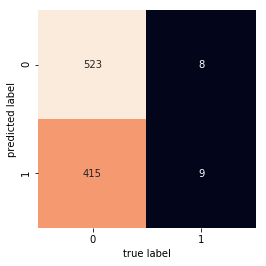

In [16]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_model, y_test_set)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');